In [ ]:
!pip install openpyxl
!pip install spark-nlp==5.5.3

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 635.7/635.7 kB 14.3 MB/s eta 0:00:00


In [ ]:
# RUN THIS FOR ALL THE MODELLING

import pandas as pd
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, udf
from pyspark.ml import Pipeline
from pyspark.ml.feature import (
    RegexTokenizer, StopWordsRemover, CountVectorizer,
    IDF, Word2Vec
)
from pyspark.ml.classification import (
    NaiveBayes, LogisticRegression, LinearSVC
)
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# For VADER lexicon-based
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')

# Optional: for transformer-based with Spark NLP
# from sparknlp.base import DocumentAssembler, Finisher
# from sparknlp.annotator import BertSentenceEmbeddings, ClassifierDLModel

# Initialize Spark session
spark = SparkSession.builder \
    .appName("SentimentAnalysisComparison") \
    .config("spark.driver.memory", "10g") \
    .config("spark.jars.packages", "com.crealytics:spark-excel_2.12:0.13.5") \
    .getOrCreate()

excel_path = "st-data-full.xlsx"
pdf1 = pd.read_excel(excel_path, sheet_name="stocktwits_1")
pdf2 = pd.read_excel(excel_path, sheet_name="stocktwits_2")

# Combine pandas DataFrames
pdf = pd.concat([pdf1, pdf2], ignore_index=True)
# Ensure columns are named 'text' and 'label'
pdf = pdf[['text', 'label']]

# Convert pandas DataFrame to Spark DataFrame
df = spark.createDataFrame(pdf)

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [ ]:
vader = SentimentIntensityAnalyzer()

def vader_sentiment(text):
    scores = vader.polarity_scores(text)
    # choose compound score thresholds
    comp = scores['compound']
    if comp >= 0.05:
        return float(2)
    elif comp <= -0.05:
        return float(1)
    else:
        return float(0)

from pyspark.sql.types import DoubleType, IntegerType
vader_udf = udf(vader_sentiment, DoubleType())

df_vader = df.withColumn("prediction_vader", vader_udf(col("text")))

In [ ]:
evaluator = MulticlassClassificationEvaluator(
    labelCol="label", predictionCol="prediction_vader", metricName="accuracy"
)
print("VADER Accuracy:", evaluator.evaluate(df_vader))

VADER Accuracy: 0.3252894614916156


In [ ]:
# === Common Preprocessing Pipeline ===
regex_tokenizer = RegexTokenizer(inputCol="text", outputCol="tokens", pattern="\\W")
stopwords_remover = StopWordsRemover(inputCol="tokens", outputCol="filtered")

# === 2. Classical ML Methods ===
# 2a. CountVectorizer + NaiveBayes
cv = CountVectorizer(inputCol="filtered", outputCol="rawFeatures")
nb = NaiveBayes(featuresCol="rawFeatures", labelCol="label", predictionCol="prediction_nb")
pipeline_nb = Pipeline(stages=[regex_tokenizer, stopwords_remover, cv, nb])
model_nb = pipeline_nb.fit(df)
pred_nb = model_nb.transform(df)
print("NaiveBayes Accuracy:", MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction_nb").evaluate(pred_nb))

# 2b. CountVectorizer + LogisticRegression
lr = LogisticRegression(featuresCol="rawFeatures", labelCol="label", predictionCol="prediction_lr", maxIter=20)
pipeline_lr = Pipeline(stages=[regex_tokenizer, stopwords_remover, cv, lr])
model_lr = pipeline_lr.fit(df)
pred_lr = model_lr.transform(df)
print("LogisticRegression Accuracy:", MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction_lr").evaluate(pred_lr))


NaiveBayes Accuracy: 0.5910875901139714
LogisticRegression Accuracy: 0.6266538953278633


In [ ]:

# Map labels: 2->2, 1->0, 0->1 to match positive(2), negative(1), neutral(0)
# If existing labels already fine, skip
# df = df.withColumn("label", col("label").cast("integer"))

# === 1. Lexicon-Based: VADER UDF ===


# # 2c. TF-IDF + LinearSVC
# idf = IDF(inputCol="rawFeatures", outputCol="features")
# svc = LinearSVC(featuresCol="features", labelCol="label", predictionCol="prediction_svc", maxIter=20)
# pipeline_svc = Pipeline(stages=[regex_tokenizer, stopwords_remover, cv, idf, svc])
# model_svc = pipeline_svc.fit(df)
# pred_svc = model_svc.transform(df)
# print("LinearSVC Accuracy:", MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction_svc").evaluate(pred_svc))

# === 3. Embedding-Based: Word2Vec + LogisticRegression ===
w2v = Word2Vec(inputCol="filtered", outputCol="w2v_features", vectorSize=50, minCount=5)
lr_w2v = LogisticRegression(featuresCol="w2v_features", labelCol="label", predictionCol="prediction_w2v", maxIter=20)
pipeline_w2v = Pipeline(stages=[regex_tokenizer, stopwords_remover, w2v, lr_w2v])
model_w2v = pipeline_w2v.fit(df)
pred_w2v = model_w2v.transform(df)
print("Word2Vec+LR Accuracy:", MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction_w2v").evaluate(pred_w2v))

# === 4. Transformer-Based: Spark NLP BERT ===
# Uncomment and configure if Spark NLP is available
# document_assembler = DocumentAssembler().setInputCol("text").setOutputCol("document")
# tokenizer = Tokenizer().setInputCols(["document"]).setOutputCol("token")
# embeddings = BertSentenceEmbeddings.pretrained("sent_bert_base_uncased", "en") \
#     .setInputCols(["document"]).setOutputCol("embeddings")
# classifier = ClassifierDLModel.pretrained("sentimentdl_use_trec6") \
#     .setInputCols(["document", "embeddings"]).setOutputCol("prediction_bert")
# finisher = Finisher().setInputCols(["prediction_bert"]).setOutputCols(["prediction_bert_str"])
# pipeline_bert = Pipeline(stages=[document_assembler, tokenizer, embeddings, classifier, finisher])
# model_bert = pipeline_bert.fit(df)
# pred_bert = model_bert.transform(df)
# pred_bert = pred_bert.withColumn("prediction_bert", col("prediction_bert_str").cast("double"))
# print("BERT Accuracy:", MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction_bert").evaluate(pred_bert))

# spark.stop()


Word2Vec+LR Accuracy: 0.5145316447470114


In [ ]:

import pandas as pd

file_path = "/content/st-data-full 2.xlsx"
df = pd.read_excel(file_path)

df = df[['text', 'label']]  # Keep only necessary columns
df.dropna(inplace=True)     # Drop rows with missing text or labels
df.head()


,text,label
0,"if you were curious, price chose the lowest ch...",1
1,"true, not even 10k followers here yet.",1
2,dogecoin co-founder billy markus hits back at ...,1
3,"i’m curious, do any bulls have a price where ...",1
4,friday everybody buy 10 more on friday,2


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df.size

1199950

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from collections import Counter
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [ ]:
df['text'] = df['text'].astype(str)

In [ ]:
print("Dataset Overview:")
print(f"Total samples: {len(df)}")
print(f"Sentiment distribution: {df['label'].value_counts().to_dict()}")
print("\nSample data:")
print(df.head())

# Calculate basic text statistics
df['text_length'] = df['text'].apply(len)
df['word_count'] = df['text'].apply(lambda x: len(x.split()))

# Text statistics by sentiment class
text_stats = df.groupby('label').agg({
    'text_length': ['mean', 'min', 'max', 'std'],
    'word_count': ['mean', 'min', 'max', 'std']
})

print("\nText statistics by sentiment:")
print(text_stats)

Dataset Overview:
Total samples: 599975
Sentiment distribution: {2: 305079, 1: 239043, 0: 55853}

Sample data:
                                                text  label
0  if you were curious, price chose the lowest ch...      1
1             true, not even 10k followers here yet.      1
2  dogecoin co-founder billy markus hits back at ...      1
3   i’m curious, do any bulls have a price where ...      1
4             friday everybody buy 10 more on friday      2

Text statistics by sentiment:
      text_length                      word_count                    
             mean min   max        std       mean min  max        std
label                                                                
0       72.746513   1   990  67.922432  13.598356   1  188  12.404004
1       77.909288   1  1021  77.339709  14.537640   1  203  14.146350
2       76.352532   1   997  79.692211  14.461480   1  201  14.590071


In [ ]:
df.label.unique()

array([1, 2, 0])

In [ ]:
import nltk
nltk.download('stopwords')
nltk.download('punkt_tab')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [ ]:

# Function to preprocess text
def preprocess_text(text):
    """Clean and tokenize text"""
    # Convert to lowercase and remove punctuation
    text = re.sub(r'[^\w\s]', '', text.lower())
    # Tokenize
    tokens = word_tokenize(text)
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words and len(word) > 2]
    return tokens

# Preprocess all texts
df['tokens'] = df['text'].apply(preprocess_text)

# Get most frequent words by sentiment
def get_top_words(df, sentiment, n=10):
    """Get top n words for a specific sentiment"""
    words = []
    for tokens in df[df['label'] == sentiment]['tokens']:
        words.extend(tokens)
    return Counter(words).most_common(n)

top_positive = get_top_words(df, 2)
top_neutral = get_top_words(df, 1)
top_negative = get_top_words(df, 0)

KeyError: 'tokens'

<ipython-input-49-b44c19a29865>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='label', data=df, palette={'1': '#FF4136', '0': '#AAAAAA', '2': '#2ECC40'})


Text(0, 0.5, 'Count')

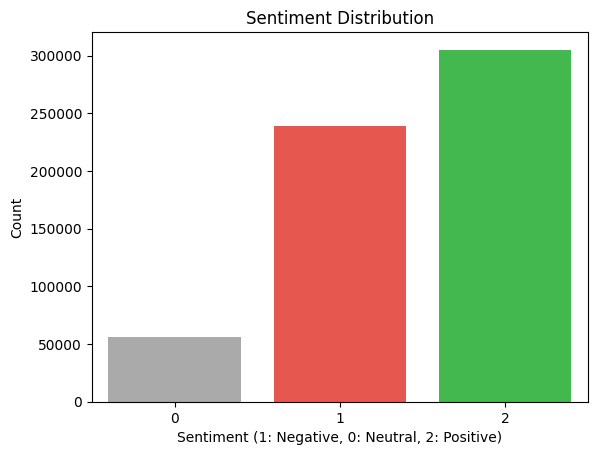

In [ ]:
# Create a figure with 3 rows for visualizations
# plt.figure(figsize=(16, 20))

# 1. Sentiment Distribution
# plt.subplot(3, 2, 1)
sns.countplot(x='label', data=df, palette={'1': '#FF4136', '0': '#AAAAAA', '2': '#2ECC40'})
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment (1: Negative, 0: Neutral, 2: Positive)')
plt.ylabel('Count')

<ipython-input-48-9eb75988883a>:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='label', y='text_length', data=df, palette={'1': '#FF4136', '0': '#AAAAAA', '2': '#2ECC40'})


Text(0, 0.5, 'Text Length (characters)')

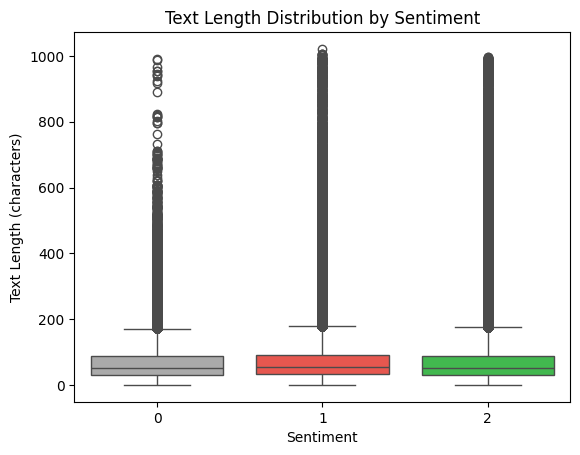

In [ ]:
sns.boxplot(x='label', y='text_length', data=df, palette={'1': '#FF4136', '0': '#AAAAAA', '2': '#2ECC40'})
plt.title('Text Length Distribution by Sentiment')
plt.xlabel('Sentiment')
plt.ylabel('Text Length (characters)')

<ipython-input-50-258710825c0b>:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='label', y='word_count', data=df, palette={'1': '#FF4136', '0': '#AAAAAA', '2': '#2ECC40'})


Text(0, 0.5, 'Word Count')

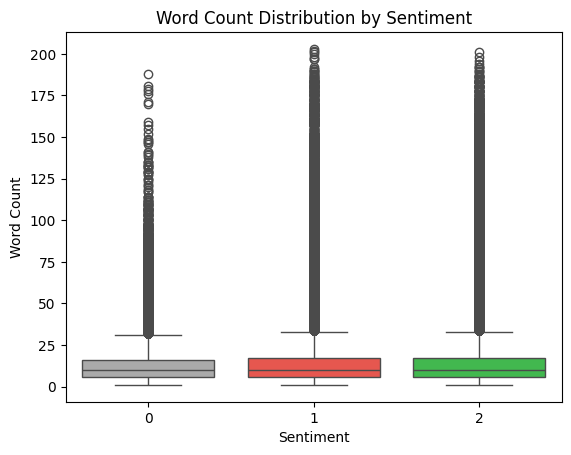

In [ ]:
sns.boxplot(x='label', y='word_count', data=df, palette={'1': '#FF4136', '0': '#AAAAAA', '2': '#2ECC40'})
plt.title('Word Count Distribution by Sentiment')
plt.xlabel('Sentiment')
plt.ylabel('Word Count')


<ipython-input-52-d660588dc707>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='label', y='avg_word_length', data=df, palette={'1': '#FF4136', '0': '#AAAAAA', '2': '#2ECC40'})


Text(0, 0.5, 'Average Word Length')

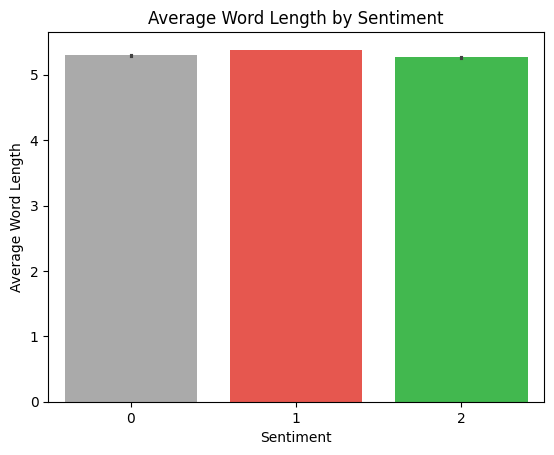

In [ ]:
# plt.subplot(3, 2, 4)
df['avg_word_length'] = df['tokens'].apply(lambda x: np.mean([len(word) for word in x]) if x else 0)
sns.barplot(x='label', y='avg_word_length', data=df, palette={'1': '#FF4136', '0': '#AAAAAA', '2': '#2ECC40'})
plt.title('Average Word Length by Sentiment')
plt.xlabel('Sentiment')
plt.ylabel('Average Word Length')

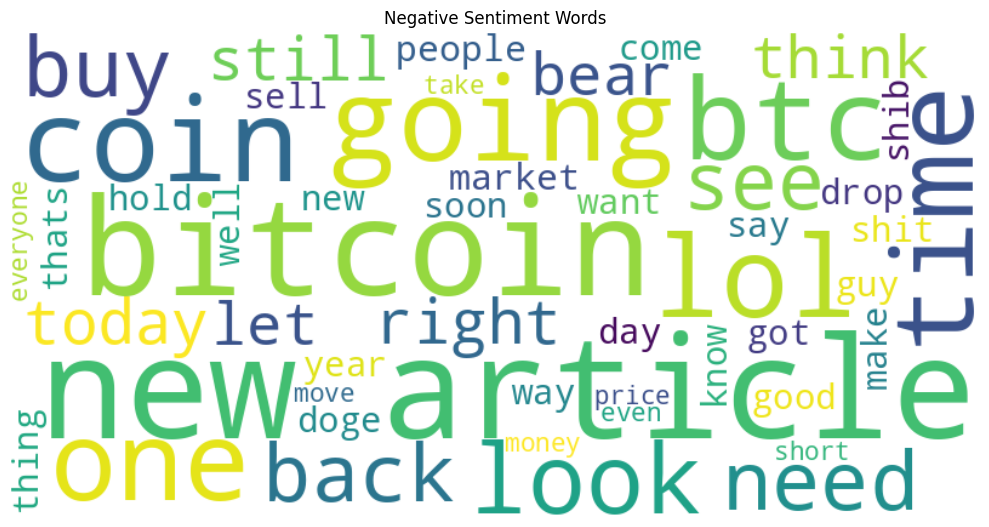

In [ ]:
def create_wordcloud(text, title):
    wordcloud = WordCloud(width=800, height=400,
                          background_color='white',
                          max_words=50).generate(text)
    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
    plt.tight_layout()
    plt.show()

additional_stop = ['crypto']
# Combine all tokens for each sentiment
negative_text = ' '.join([(' '.join(tokens)).replace('crypto','') for tokens in df[df['label'] == 1]['tokens']])
neutral_text = ' '.join([(' '.join(tokens)).replace('crypto','') for tokens in df[df['label'] == 0]['tokens']])
positive_text = ' '.join([(' '.join(tokens)).replace('crypto','') for tokens in df[df['label'] == 2]['tokens']])

# Create word clouds for each sentiment
create_wordcloud(negative_text, 'Negative Sentiment Words')


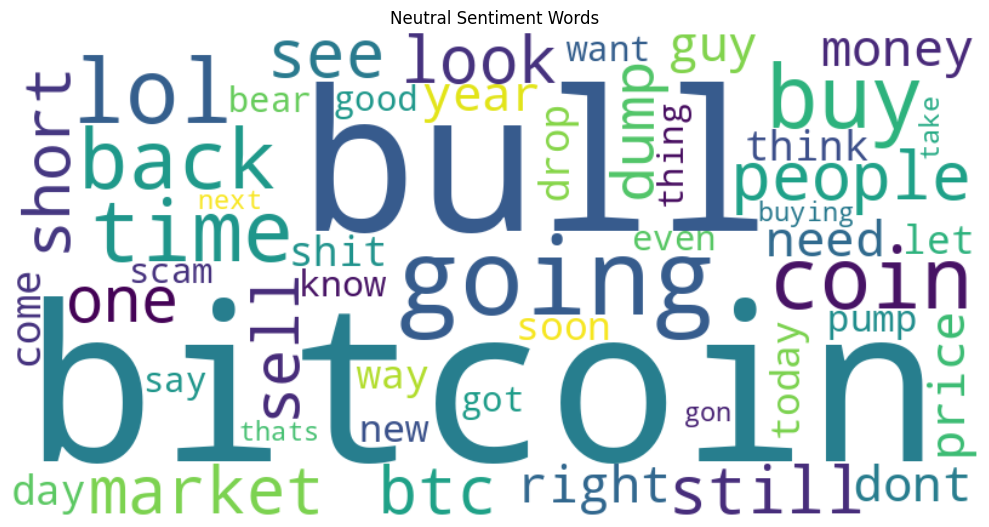

In [ ]:
create_wordcloud(neutral_text, 'Neutral Sentiment Words')

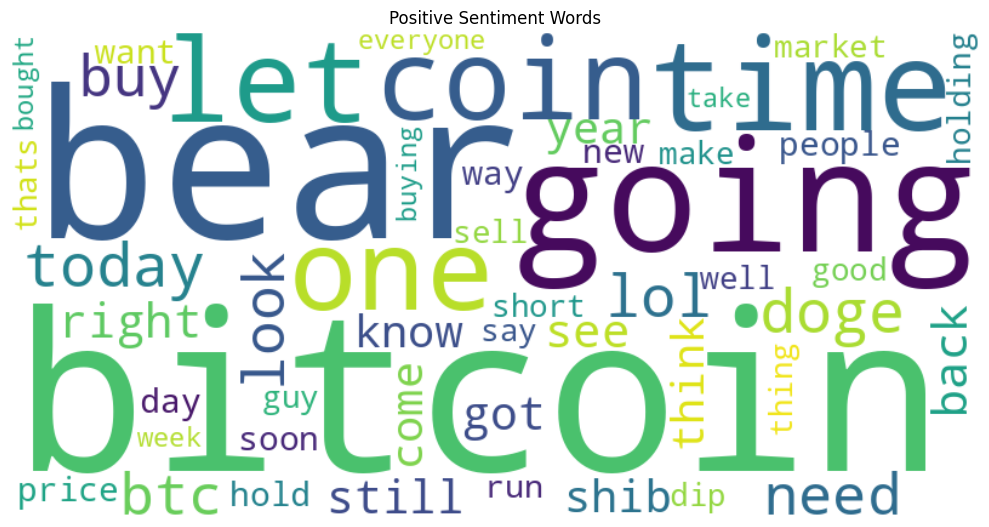

In [ ]:
create_wordcloud(positive_text, 'Positive Sentiment Words')


In [ ]:
top_neg_df = pd.DataFrame(top_negative, columns=['word', 'count'])
top_neu_df = pd.DataFrame(top_neutral, columns=['word', 'count'])
top_pos_df = pd.DataFrame(top_positive, columns=['word', 'count'])

# Add sentiment label
top_neg_df['sentiment'] = 'Negative'
top_neu_df['sentiment'] = 'Neutral'
top_pos_df['sentiment'] = 'Positive'

# Combine data
top_words_df = pd.concat([top_neg_df, top_neu_df, top_pos_df])

# Create bar chart
fig3 = px.bar(top_words_df, x='word', y='count', color='sentiment',
              facet_col='sentiment',
              color_discrete_map={'Negative': '#FF4136', 'Neutral': '#AAAAAA', 'Positive': '#2ECC40'},
              title='Top Words by Sentiment')
fig3.update_xaxes(tickangle=45)
fig3.show()

# Correlation between text features and sentiment
corr_df = df[['label', 'text_length', 'word_count', 'avg_word_length']]
correlation = corr_df.corr()
print("\nCorrelation between features:")
print(correlation)

fig4 = px.imshow(correlation, text_auto=True,
                 color_continuous_scale='RdBu_r',
                 title='Correlation Between Text Features and Sentiment')
fig4.show()

# Output summary statistics
print("\nSummary Statistics for Text Features:")
print(df[['text_length', 'word_count', 'avg_word_length']].describe())

sentiment_mapping = {'1': '#FF4136', '0': '#AAAAAA', '2': '#2ECC40'}
df['sentiment_label'] = df['label'].map(sentiment_mapping)
print("\nSummary by Sentiment Class:")
print(df.groupby('sentiment_label')[['text_length', 'word_count', 'avg_word_length']].mean())


Correlation between features:
                    label  text_length  word_count  avg_word_length
label            1.000000     0.004271    0.010853        -0.031191
text_length      0.004271     1.000000    0.989487         0.172245
word_count       0.010853     0.989487    1.000000         0.097110
avg_word_length -0.031191     0.172245    0.097110         1.000000



Summary Statistics for Text Features:
         text_length     word_count  avg_word_length
count  599975.000000  599975.000000    599975.000000
mean       76.637085      14.411474         5.314252
std        77.743191      14.225506         1.109000
min         1.000000       1.000000         0.000000
25%        32.000000       6.000000         4.666667
50%        53.000000      10.000000         5.250000
75%        91.000000      17.000000         5.937500
max      1021.000000     203.000000       176.000000

Summary by Sentiment Class:
Empty DataFrame
Columns: [text_length, word_count, avg_word_length]
Index: []


<ipython-input-46-903e085b5246>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='label', data=df, palette={'1': '#FF4136', '0': '#AAAAAA', '2': '#2ECC40'})
<ipython-input-46-903e085b5246>:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='label', y='text_length', data=df, palette={'1': '#FF4136', '0': '#AAAAAA', '2': '#2ECC40'})
<ipython-input-46-903e085b5246>:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='label', y='word_count', data=df, palette={'1': '#FF4136', '0': '#AAAAAA', '2': '#2ECC40'})
<ipython-input-46-903e085b5246>:2

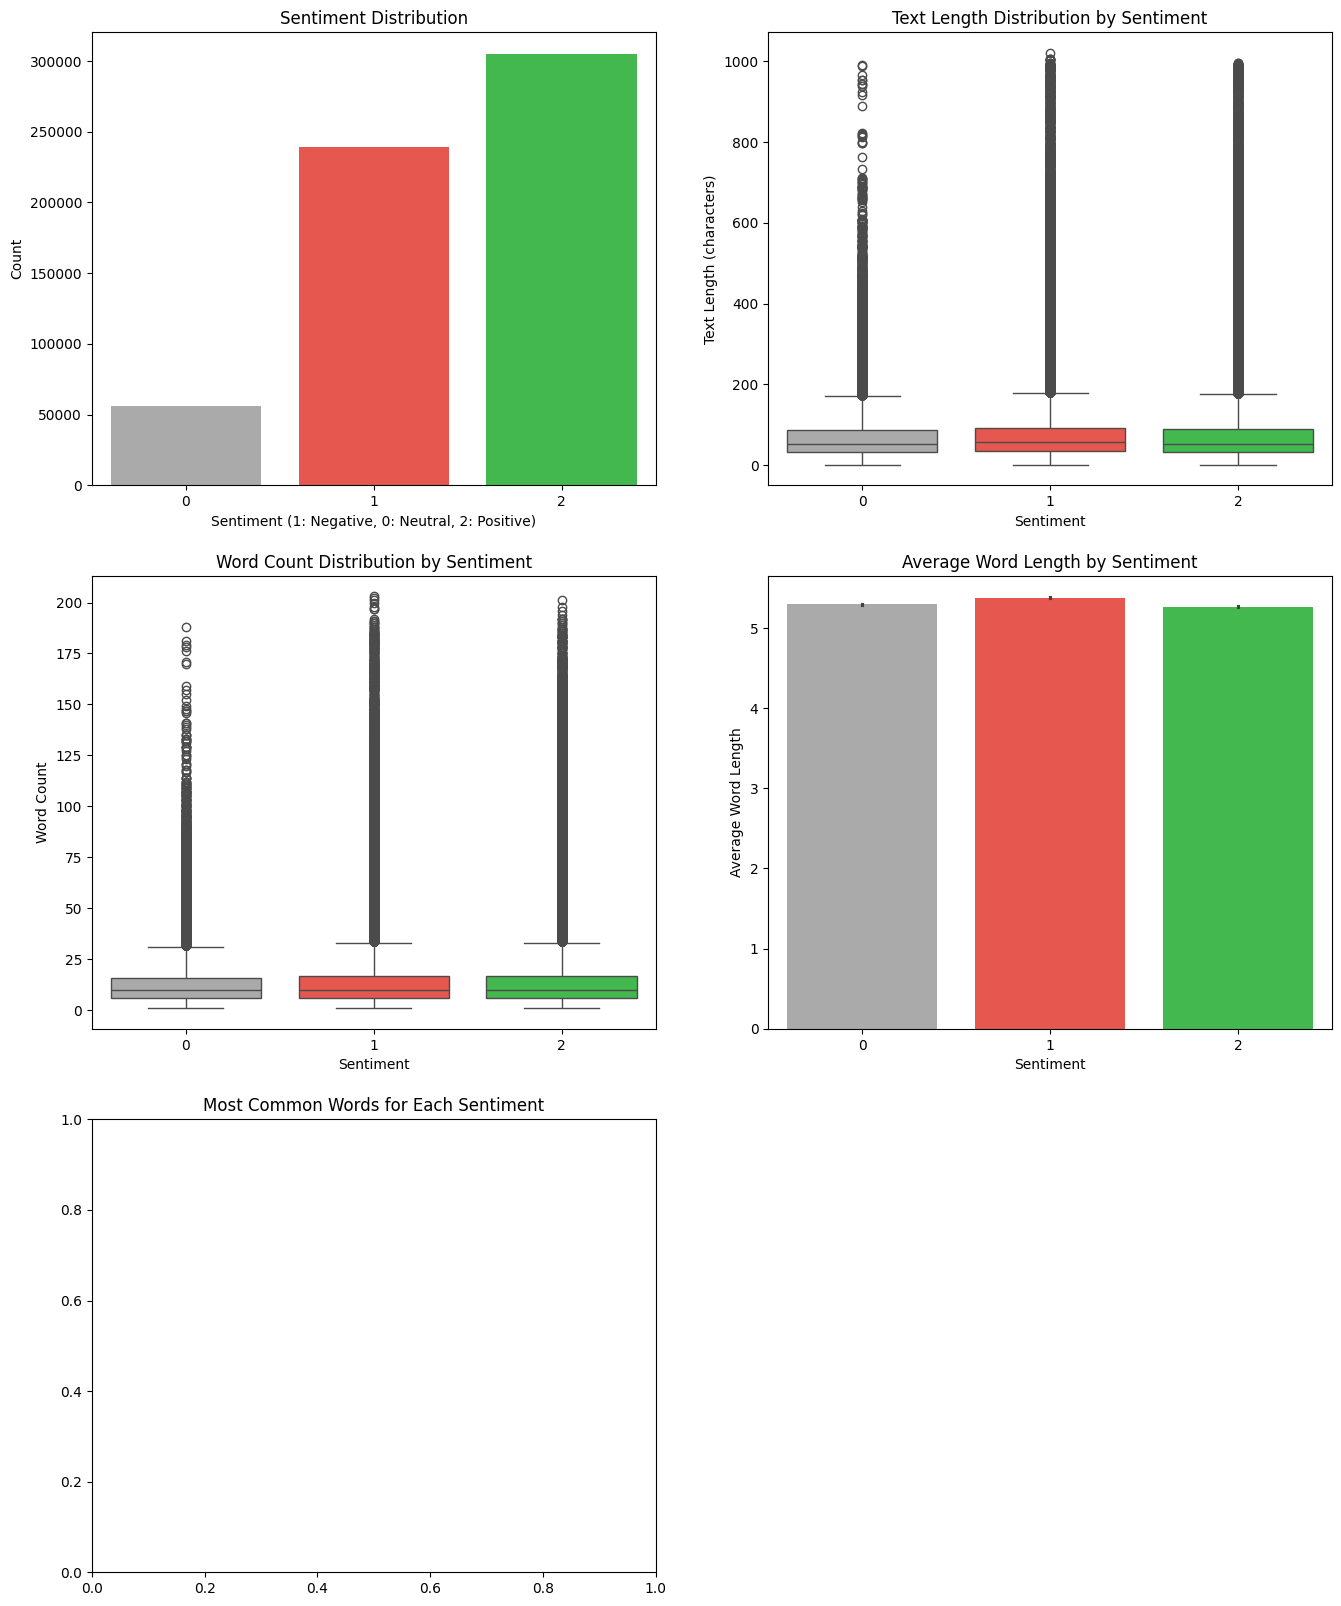

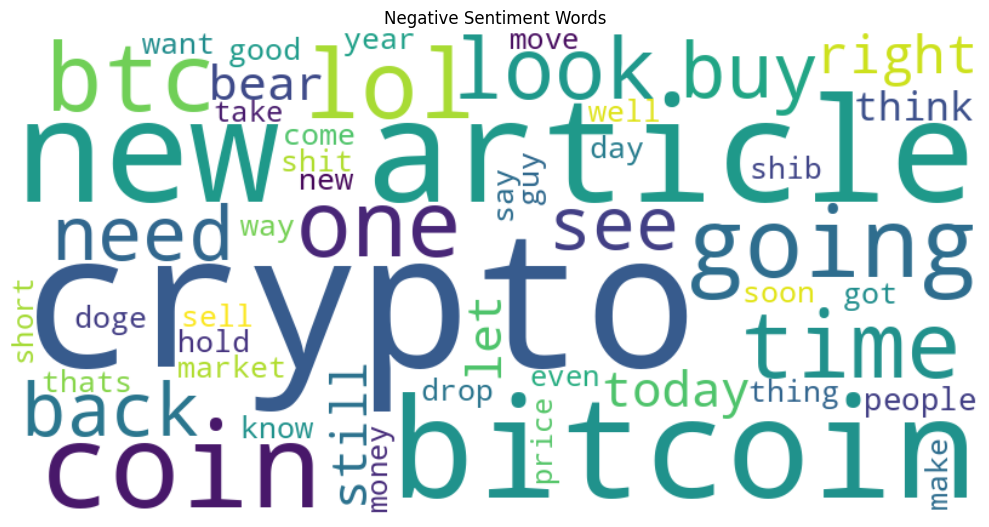

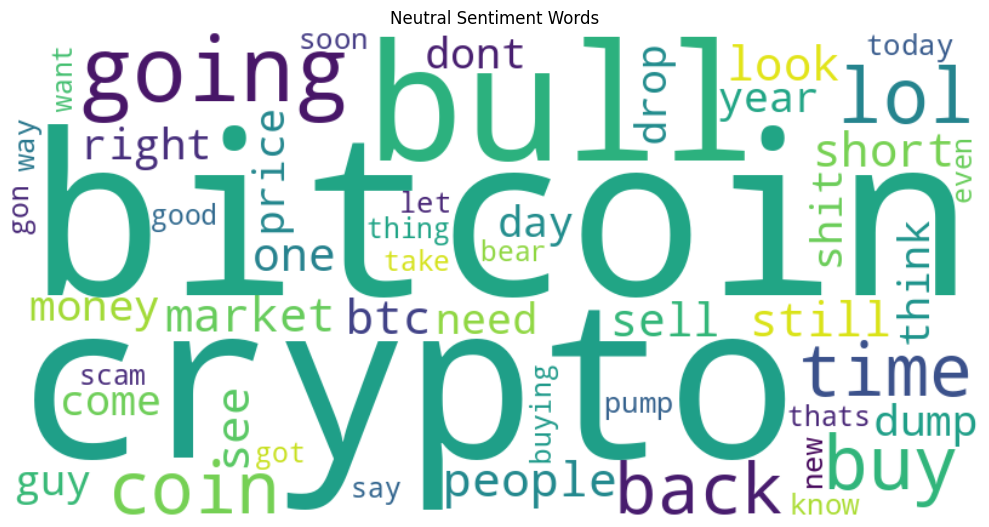

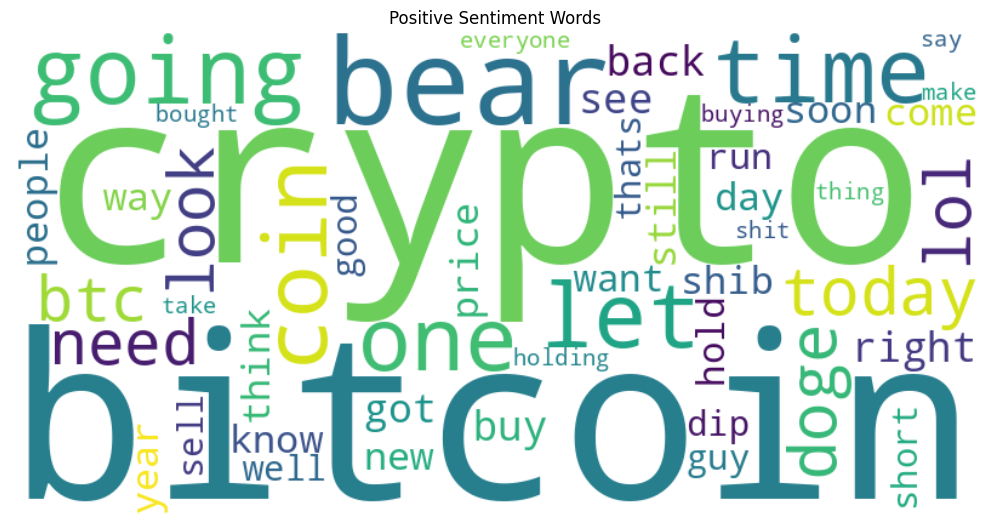

<Figure size 640x480 with 0 Axes>

In [ ]:
# Create a figure with 3 rows for visualizations
plt.figure(figsize=(16, 20))

# 1. Sentiment Distribution
plt.subplot(3, 2, 1)
sns.countplot(x='label', data=df, palette={'1': '#FF4136', '0': '#AAAAAA', '2': '#2ECC40'})
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment (1: Negative, 0: Neutral, 2: Positive)')
plt.ylabel('Count')

# 2. Text Length Distribution by Sentiment
plt.subplot(3, 2, 2)
sns.boxplot(x='label', y='text_length', data=df, palette={'1': '#FF4136', '0': '#AAAAAA', '2': '#2ECC40'})
plt.title('Text Length Distribution by Sentiment')
plt.xlabel('Sentiment')
plt.ylabel('Text Length (characters)')

# 3. Word Count Distribution by Sentiment
plt.subplot(3, 2, 3)
sns.boxplot(x='label', y='word_count', data=df, palette={'1': '#FF4136', '0': '#AAAAAA', '2': '#2ECC40'})
plt.title('Word Count Distribution by Sentiment')
plt.xlabel('Sentiment')
plt.ylabel('Word Count')

# 4. Average Word Length by Sentiment
plt.subplot(3, 2, 4)
df['avg_word_length'] = df['tokens'].apply(lambda x: np.mean([len(word) for word in x]) if x else 0)
sns.barplot(x='label', y='avg_word_length', data=df, palette={'1': '#FF4136', '0': '#AAAAAA', '2': '#2ECC40'})
plt.title('Average Word Length by Sentiment')
plt.xlabel('Sentiment')
plt.ylabel('Average Word Length')

# 5. Word Clouds for each sentiment
plt.subplot(3, 2, 5)
plt.title('Most Common Words for Each Sentiment')

# Create word clouds
def create_wordcloud(text, title):
    wordcloud = WordCloud(width=800, height=400,
                          background_color='white',
                          max_words=50).generate(text)
    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
    plt.tight_layout()
    plt.show()

# Combine all tokens for each sentiment
negative_text = ' '.join([' '.join(tokens) for tokens in df[df['label'] == 1]['tokens']])
neutral_text = ' '.join([' '.join(tokens) for tokens in df[df['label'] == 0]['tokens']])
positive_text = ' '.join([' '.join(tokens) for tokens in df[df['label'] == 2]['tokens']])

# Create word clouds for each sentiment
create_wordcloud(negative_text, 'Negative Sentiment Words')
create_wordcloud(neutral_text, 'Neutral Sentiment Words')
create_wordcloud(positive_text, 'Positive Sentiment Words')

# Adjust layout and display plots
plt.tight_layout()
plt.show()


🟡 PART 1: VADER SENTIMENT ANALYSIS (Baseline)

🔹 Step 1: Install & Import VADER

In [ ]:
!pip install vaderSentiment

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 2.7 MB/s eta 0:00:00


🔹 Step 2: Create a VADER Scoring Function

In [ ]:
analyzer = SentimentIntensityAnalyzer()

def get_vader_sentiment(text):
    score = analyzer.polarity_scores(text)['compound']
    if score >= 0.05:
        return 1  # Positive
    elif score <= -0.05:
        return 2  # Negative
    else:
        return 0  # Neutral


🔹 Step 3: Apply VADER to Dataset

In [ ]:
# Ensure all entries are strings
df['text'] = df['text'].astype(str)


In [ ]:
df['vader_pred'] = df['text'].apply(get_vader_sentiment)


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

print("VADER Classification Report:\n")
print(classification_report(df['label'], df['vader_pred']))


VADER Classification Report:

              precision    recall  f1-score   support

           0       0.08      0.34      0.13     55853
           1       0.38      0.36      0.37    239043
           2       0.43      0.20      0.27    305079

    accuracy                           0.28    599975
   macro avg       0.30      0.30      0.26    599975
weighted avg       0.38      0.28      0.30    599975



🔵 PART 2: HUGGINGFACE ROBERTA MODEL (Advanced)

🔹 Step 1: Install Huggingface Transformers

In [ ]:
!pip install transformers


🔹 Step 2: Load RoBERTa Pre-trained Model for Sentiment

Let's use "cardiffnlp/twitter-roberta-base-sentiment" (trained on Twitter, ideal for crypto-style posts):

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
import numpy as np

# Load tokenizer and model
model_name = "cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)
model.eval()


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/747 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
             

🔹 Step 3: Define Prediction Function for RoBERTa

In [ ]:
def get_roberta_sentiment(text):
    tokens = tokenizer(text, return_tensors="pt", truncation=True, padding=True)
    with torch.no_grad():
        output = model(**tokens)
    probs = torch.nn.functional.softmax(output.logits, dim=1)
    label = torch.argmax(probs).item()
    # Twitter-RoBERTa label mapping: 0=Negative, 1=Neutral, 2=Positive
    if label == 2:
        return 1  # Positive
    elif label == 0:
        return 2  # Negative
    else:
        return 0  # Neutral


🔹 Step 4: Apply RoBERTa in Batches (for speed)

In [ ]:
# Limit to first 5000 rows initially (for speed during testing)
df_subset = df.head(500).copy()
df_subset['roberta_pred'] = df_subset['text'].apply(get_roberta_sentiment)


🔹 Step 5: Evaluate RoBERTa

In [ ]:
print("RoBERTa Classification Report:\n")
print(classification_report(df_subset['label'], df_subset['roberta_pred']))
